In [2]:
import numpy as np
import os
import jax.numpy as jnp
from jax import grad,jacfwd,jacrev,linearize,vmap,partial,vjp,jvp,jit
import matplotlib.pyplot as plt

In [50]:
def shorten(arr, factor=10):
    arr_shape = list(arr.shape)
    arr_shape[0] = int(arr_shape[0]/factor)
    new_arr = np.zeros(arr_shape)
    for i in range(arr_shape[0]):
        new_arr[i] = arr[i*factor]
    return new_arr

# Change here for different observation gap and observation covariance parameter
mu=1.6
ob_gap=0.05

os.chdir('/home/shashank/Documents/Data Assimilation/ENKF_for_CLVs/data/fix_gap')
#factor in time
factor=int(ob_gap/0.01)

#Partial or full observation
ob_dim=5
lambda_=1.0  
bias=4.0     
#load the state
state=shorten(np.load('Trajectory_0.01_seed_35.npy'),factor)

k=5
N=50 #,120,140
l_scale=2
alpha=1.0025

# State and obs
os.chdir(os.getcwd()+'/ob{}'.format(k)) 
obs=np.load('ob{}_gap_{}_H2__mu={}_obs_cov1.npy'.format(k,ob_gap,mu))

#Go inside the data folder......................................
file_label='bias={}_obs={}_ens={}_Mcov={},ocov={}_,gap={}_alpha={}_loc=gaspri_r={}'.format(bias,ob_dim,N,lambda_,mu,ob_gap,alpha,l_scale)
os.chdir(file_label)
print(os.getcwd())
#Load data....
f_ens=np.load(file_label+'f_ensemble.npy')
a_ens=np.load(file_label+'a_ensemble.npy') #ens has shape:=[time steps,system dimension,ensemble number]
f_mean=np.mean(f_ens,axis=2)
a_mean=np.mean(a_ens,axis=2)
# number of assimilations
time=np.arange(int(3000/factor))

/home/shashank/Documents/Data Assimilation/ENKF_for_CLVs/data/fix_gap/ob5/bias=4.0_obs=5_ens=50_Mcov=1.0,ocov=1.6_,gap=0.05_alpha=1.0025_loc=gaspri_r=2


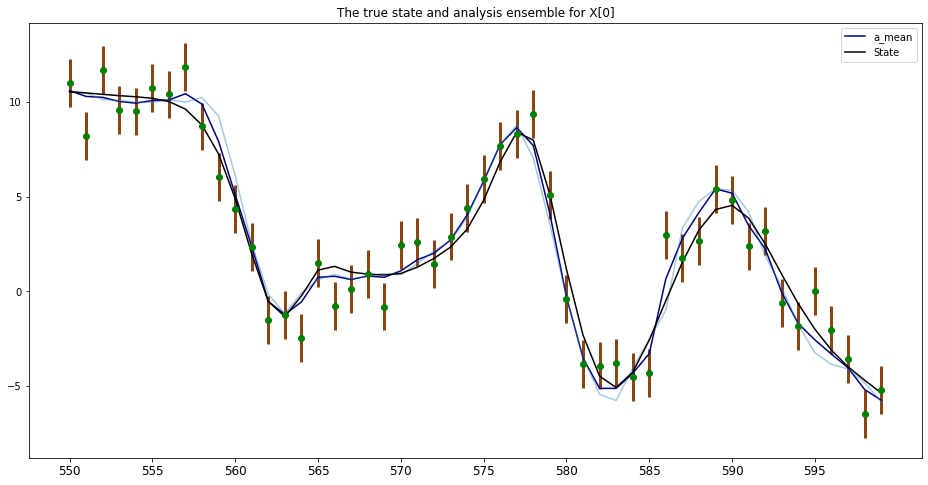

In [59]:
plt.figure(figsize=(16,8))
# Start time and end time chosen to view a part of time series
t_start=550
t_stop=600
# component to view
comp_=0

#plt.ylim(-15,15)
#for i in range(15):
plt.plot(time[t_start:t_stop],a_mean[t_start:t_stop,comp_],c='navy',label='a_mean',alpha=1)
plt.plot(time[t_start:t_stop],f_mean[t_start:t_stop,comp_],linestyle='solid',alpha=0.4)  
plt.plot(time[t_start:t_stop],state[t_start:t_stop,comp_],c='black',label='State')
if (comp_%2==0):
    #plt.scatter(time[t_start:t_stop],obs[t_start:t_stop,int(comp_/2)],c='r',marker='.',label='obs')
    plt.errorbar(time[t_start:t_stop], obs[t_start:t_stop,int(comp_/2)], yerr=np.sqrt(mu), fmt='o',alpha=1, color='green',
                    ecolor='saddlebrown', elinewidth=3, capsize=0)
plt.legend()
plt.title(r'The true state and analysis ensemble for X[{}]'.format(comp_))
plt.xticks(time[t_start:t_stop][::5],fontsize=12)
plt.legend()

In [42]:
# Jacobian of L96
def f(x):
    "Function to be used for compuation of ode in scipy.integrate.solve_ivp"
    dx_dt=(jnp.roll(x,-1)-jnp.roll(x,2))*jnp.roll(x,1)-x
    return dx_dt+10

Jac_f=jacfwd(f)

In [60]:
fro_norm=np.zeros(len(time))
for i in range(len(time)):
    J_t_state=Jac_f(state[i])
    J_t_analysis=Jac_f(a_ens[i,:,8])
    fro_norm[i]=np.linalg.norm(J_t_state-J_t_analysis,ord='fro')    

Text(0.5, 1.0, 'Error in Jacobian')

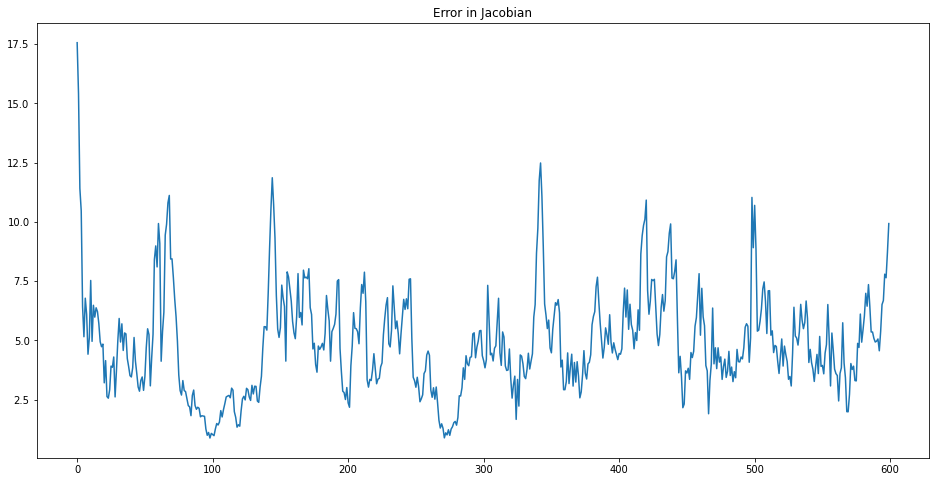

In [61]:
plt.figure(figsize=(16,8))
#plt.yscale('log')
plt.plot(time,fro_norm,label='Gap={}'.format(ob_gap))
plt.title('Error in Jacobian')

In [28]:
# Weird error in trajectory spotted
state_cov=np.load('/home/shashank/Documents/Data Assimilation/ENKF_for_CLVs/data/fix_cov/Trajectory_0.01_seed_35.npy')
state_gap=np.load('/home/shashank/Documents/Data Assimilation/ENKF_for_CLVs/data/fix_gap/Trajectory_0.01_seed_35.npy')

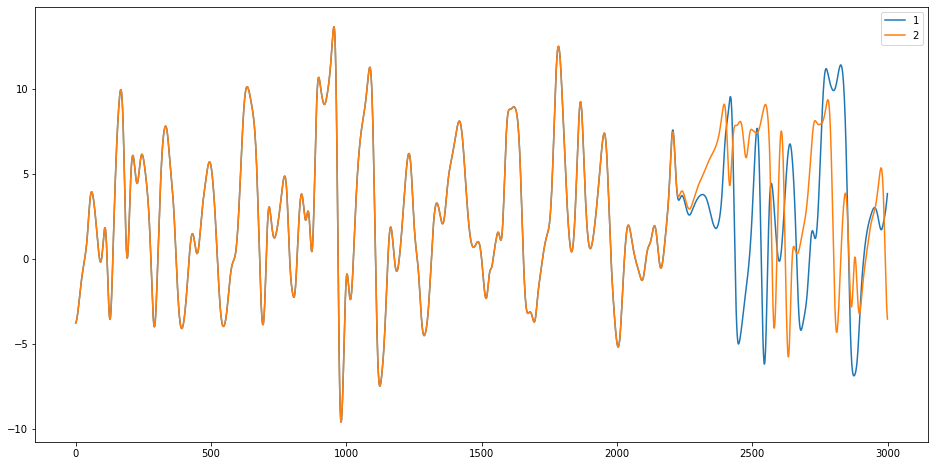

In [49]:
plt.figure(figsize=(16,8))
plt.plot(np.arange(3000),state_cov[:,4],label='1')
plt.plot(np.arange(3000),state_gap[:,4],label='2')
plt.legend()

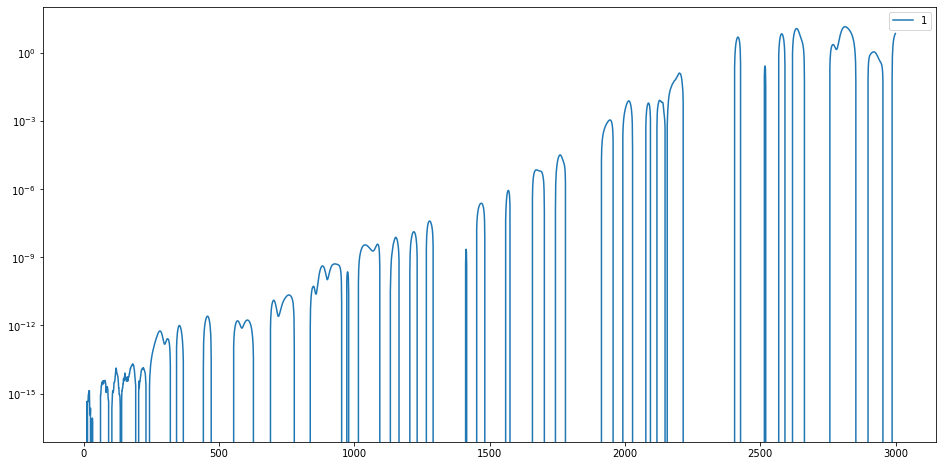

In [58]:
plt.figure(figsize=(16,8))
plt.yscale('log')
plt.plot(np.arange(3000),state_cov[:,4]-state_gap[:,4],label='1')
#plt.plot(np.arange(3000),state_gap[:,4],label='2')
plt.legend()

An interesting question to look at this, if the past is so similar, but the futures are so different,
how do clvs look like near the transition? How does the norm increase?